In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import warnings
from pathlib import Path
from pandas import date_range

import pycompo.core.composite as pccompo
import pycompo.core.utils as pcutil
from pycompo.core.sst_features import set_global_feature_id

warnings.filterwarnings(action='ignore')

# read in configuration file
config_file = "/home/m/m300738/libs/pycompo/config/settings_ngc5004_pc05.yaml"
config = pcutil.read_yaml_config(config_file)

start_time = config['data']['analysis_time'][0]
end_time = config['data']['analysis_time'][1]
analysis_times = [
    np.datetime64(t) for t in date_range(
        np.datetime64(start_time), np.datetime64(end_time), freq='MS',
        )
    ]

feature_var = config['data']['feature_var']
analysis_idf = f"{config['exp']}_{config['pycompo_name']}"

### Preparations for composite subsampling

In [ ]:
# load feature_props
inpath = Path(f"{config['data']['outpath']}/{analysis_idf}/")
infile = Path(f"{analysis_idf}_feature_props_alltrops_all.nc")
feature_props_alltrops = xr.open_dataset(str(inpath/infile))
feature_props_alltrops_quartiles = feature_props_alltrops.quantile(
    [0.25, 0.50, 0.75]
    )

# build rainbelt if necessary
if config['composite']['rainbelt_subsampling']['switch']:
    rainbelt = pccompo.get_rainbelt(analysis_times, config, quantile=0.8)
    rainbelt = rainbelt.compute()
    infile = Path(f"{analysis_idf}_feature_props_rainbelt_all.nc")
    feature_props_rainbelt = xr.open_dataset(str(inpath/infile))
    feature_props_rainbelt_quartiles = feature_props_rainbelt.quantile(
        [0.25, 0.50, 0.75]
        )

### Visualization of feature statistics

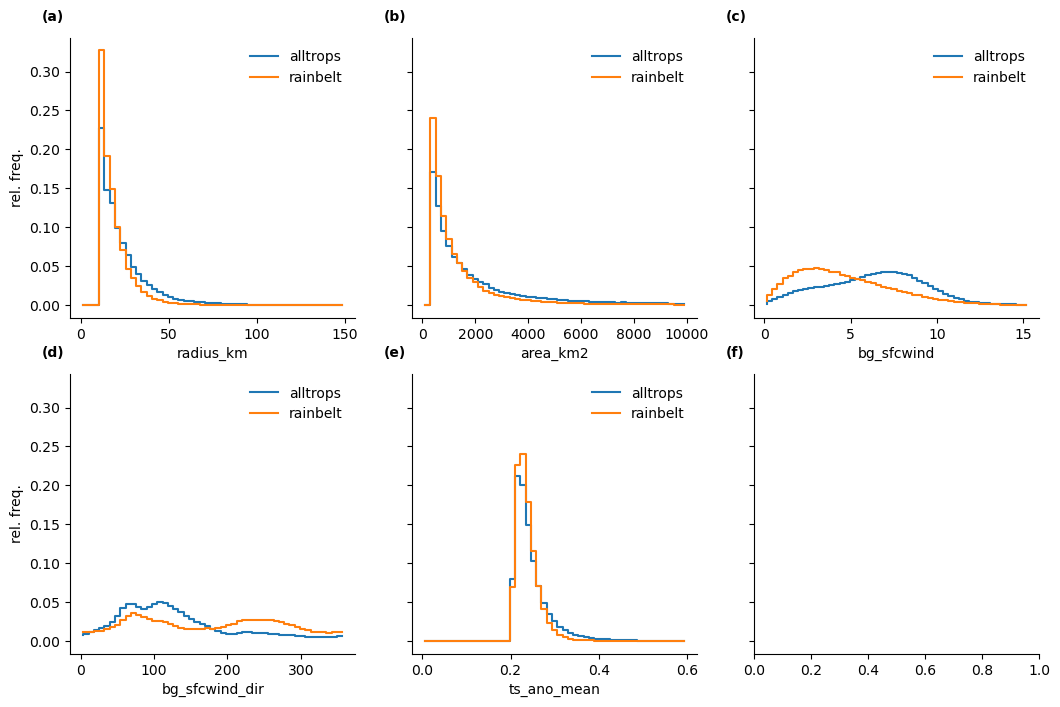

In [ ]:
import matplotlib.pyplot as plt
import hfplot.figure.figure as hffig

bins = {
    'radius_km': np.arange(0, 153, 3),
    'area_km2': np.arange(0, 10100, 200),
    'bg_sfcwind': np.arange(0, 15.3, 0.3),
    'bg_sfcwind_dir': np.arange(0, 360.2, 7.2),
    'ts_ano_mean': np.arange(0, 0.612, 0.012),
}

def get_bin_centers(bin_edges: np.ndarray) -> np.ndarray:
    return (bin_edges[:-1] + bin_edges[1:]) / 2

stats_list = \
    ['radius_km', 'area_km2', 'bg_sfcwind', 'bg_sfcwind_dir', 'ts_ano_mean']
fig, axs = hffig.init_subfig(
    style=None, asprat=(12.5, 8), nrow=2, ncol=3, sharex=False, sharey=True,
    )
for i, var in enumerate(stats_list):
    counts_alltrops, bins_alltrops = np.histogram(
        feature_props_alltrops[var], bins=bins[var],
        )
    counts_rainbelt, bins_rainbelt = np.histogram(
        feature_props_rainbelt[var], bins=bins[var],
        )
    rel_freq_alltrops = counts_alltrops/counts_alltrops.sum()
    rel_freq_rainbelt = counts_rainbelt/counts_rainbelt.sum()

    axs.ravel()[i].step(
        get_bin_centers(bins_alltrops), rel_freq_alltrops, label='alltrops'
        )
    axs.ravel()[i].step(
        get_bin_centers(bins_rainbelt), rel_freq_rainbelt, label='rainbelt'
        )
    axs.ravel()[i].legend(frameon=False)
    axs.ravel()[i].set_xlabel(var)
axs.ravel()[0].set_ylabel('rel. freq.')
axs.ravel()[3].set_ylabel('rel. freq.')
plt.savefig(
    f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
    f'{analysis_idf}/{analysis_idf}_feature_stats_all.png', dpi=600,
    )
plt.show()


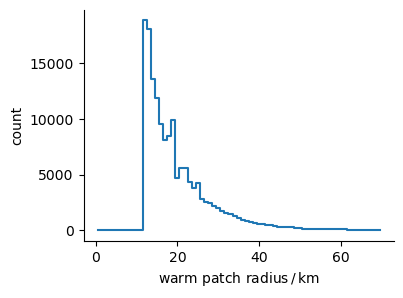

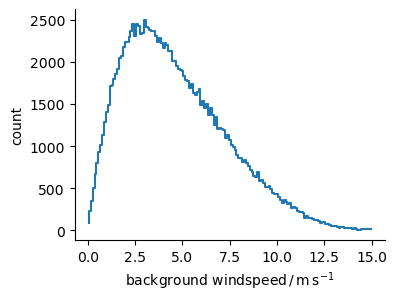

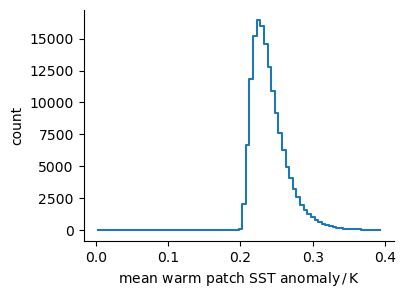

In [19]:
import matplotlib.pyplot as plt
import hfplot.figure.figure as hffig

bins = {
    'radius_km': np.arange(0, 71, 1),
    'bg_sfcwind': np.arange(0, 15.1, 0.1),
    'ts_ano_mean': np.arange(0, 0.4, 0.005),
}

def get_bin_centers(bin_edges: np.ndarray) -> np.ndarray:
    return (bin_edges[:-1] + bin_edges[1:]) / 2

stats_list = ['radius_km', 'bg_sfcwind', 'ts_ano_mean']
stats_labels = [
    'warm patch radius$\,$/$\,$km',
    'background windspeed$\,$/$\,$m$\,$s$^{-1}$',
    'mean warm patch SST anomaly$\,$/$\,$K',]
for i, var in enumerate(stats_list):
    fig, axs = hffig.init_fig(style=None, asprat=(4, 3),)
    counts_rainbelt, bins_rainbelt = np.histogram(
        feature_props_rainbelt[var], bins=bins[var],
        )
    rel_freq_rainbelt = counts_rainbelt/counts_rainbelt.sum()
    axs[0, 0].step(get_bin_centers(bins_rainbelt), counts_rainbelt,)
    axs[0, 0].set_xlabel(stats_labels[i])
    axs[0, 0].set_ylabel('count')
    #plt.savefig(
        #f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
        #f'{analysis_idf}/{analysis_idf}_feature_stats_all.png', dpi=600,
        #)
    plt.show()

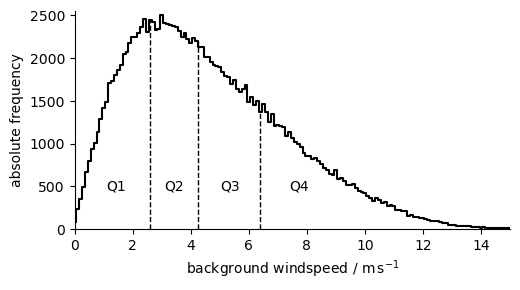

In [57]:
import matplotlib.pyplot as plt
import hfplot.figure.figure as hffig

bins = np.arange(0, 15.1, 0.1)

def get_bin_centers(bin_edges: np.ndarray) -> np.ndarray:
    return (bin_edges[:-1] + bin_edges[1:]) / 2

stats_label = 'background windspeed / m$\,$s$^{-1}$'
fig, axs = hffig.init_fig(style=None, asprat=(5.3, 3),)
counts_rainbelt, bins_rainbelt = np.histogram(
    feature_props_rainbelt['bg_sfcwind'], bins=bins,
    )
rel_freq_rainbelt = counts_rainbelt/counts_rainbelt.sum()
axs[0, 0].step(get_bin_centers(bins_rainbelt), counts_rainbelt, color='k')
axs[0, 0].set_xlabel(stats_label)
axs[0, 0].set_ylabel('absolute frequency')
for quartile in feature_props_rainbelt_quartiles['bg_sfcwind']:
    plt.vlines(
        x=quartile.values, ymin=0,
        ymax=counts_rainbelt[np.abs(bins_rainbelt - quartile.values).argmin()],
        lw=1, colors='k', ls='--')
plt.text(1.1, 450, 'Q1')
plt.text(3.1, 450, 'Q2')
plt.text(5, 450, 'Q3')
plt.text(7.4, 450, 'Q4')
plt.xlim(0, 15)
plt.ylim(0, 2550)
#axs[0, 0].set_title('Distribution of background surface wind speed', weight='bold')
plt.tight_layout()
plt.savefig(
    f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
    f'{analysis_idf}/{analysis_idf}_feature_stats_bg_sfcwind.png', dpi=600,
    )
plt.show()

In [34]:
closest_index = np.abs(bins_rainbelt - quartile.values).argmin()
closest_index

64

In [35]:
counts_rainbelt[np.abs(bins_rainbelt - quartile.values).argmin()]

1370

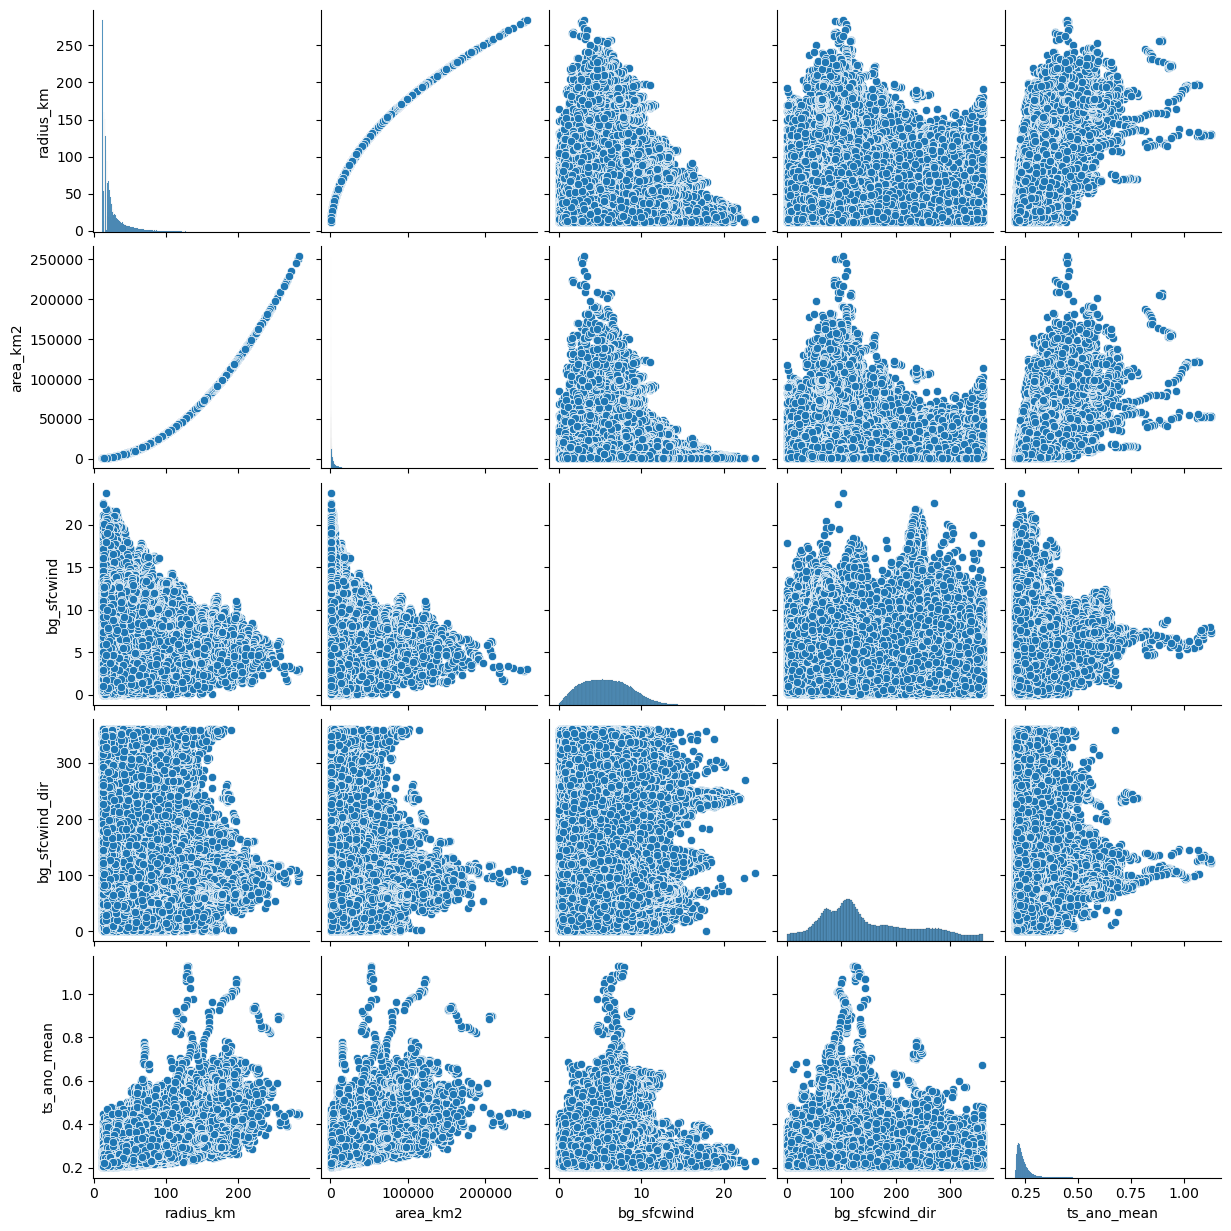

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to dataframe
df = feature_props_alltrops.to_dataframe().reset_index()

# (Optional) drop coordinate columns if you only want dataset variables
df_vars = df[feature_props_alltrops[stats_list].data_vars]

# Create pairplot
sns.pairplot(df_vars)
plt.show()

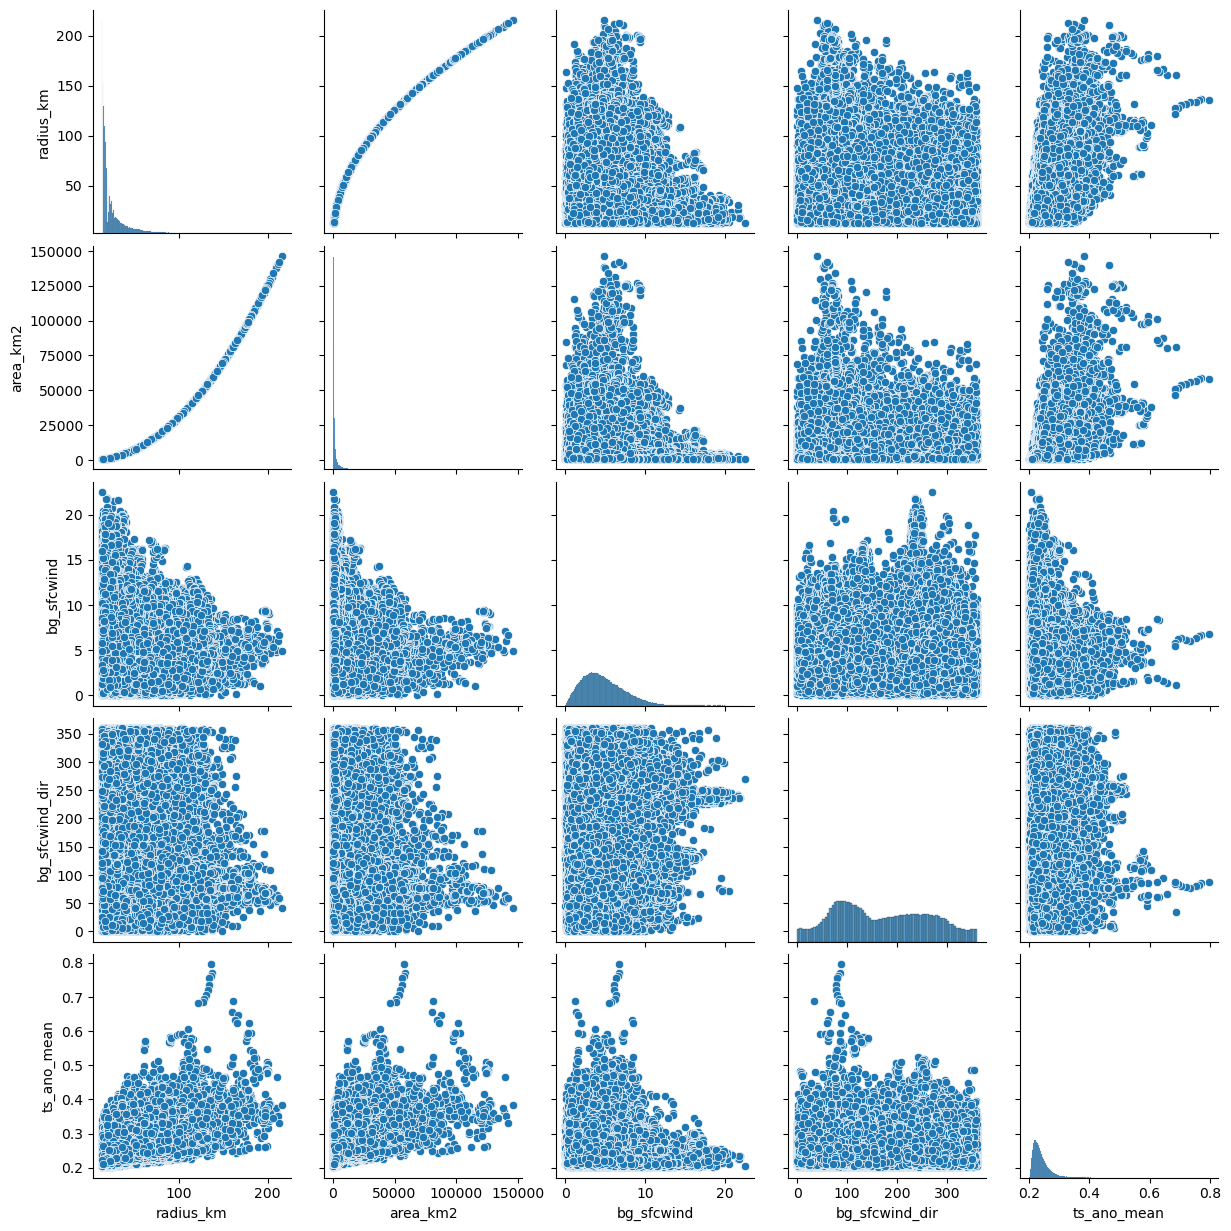

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to dataframe
df = feature_props_rainbelt.to_dataframe().reset_index()

# (Optional) drop coordinate columns if you only want dataset variables
df_vars = df[feature_props_rainbelt[stats_list].data_vars]

# Create pairplot
sns.pairplot(df_vars)
plt.show()